In [1]:
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
import matplotlib.pyplot as plt
import numpy as np

/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_without_missing', 'saug

/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/common.py:263: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return pd.Period(val, freq)


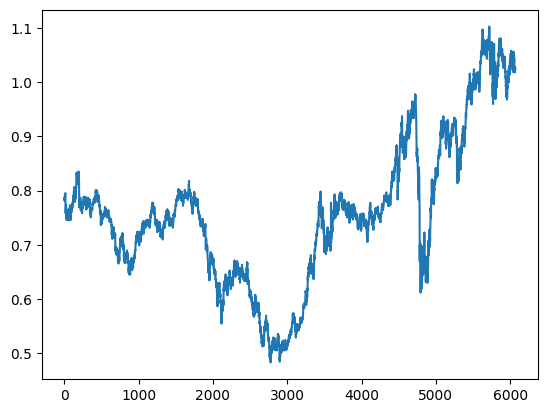

In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names

print(dataset_names)
dataset = get_dataset('exchange_rate')
entry = next(iter(dataset.train))
print(dataset.metadata)
data_dim = dataset.metadata.feat_static_cat[0].cardinality
target = entry['target']
print(target.shape)
plt.plot(np.arange(target.shape[0]),target)
plt.show()

freq='1B' target=None feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='8')] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=30
(6071,)


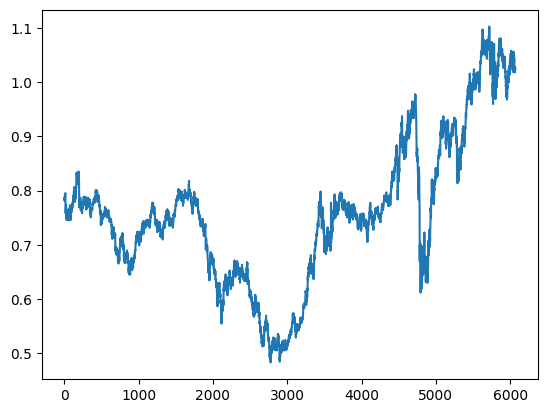

In [3]:
entry = next(iter(dataset.train))
print(dataset.metadata)
data_dim = dataset.metadata.feat_static_cat[0].cardinality
target = entry['target']
print(target.shape)
plt.plot(np.arange(target.shape[0]),target)
plt.show()

Series 0 - Static Categorical Feature: [0]
Series 1 - Static Categorical Feature: [1]
Series 2 - Static Categorical Feature: [2]
Series 3 - Static Categorical Feature: [3]
Series 4 - Static Categorical Feature: [4]
Series 5 - Static Categorical Feature: [5]
Series 6 - Static Categorical Feature: [6]
Series 7 - Static Categorical Feature: [7]


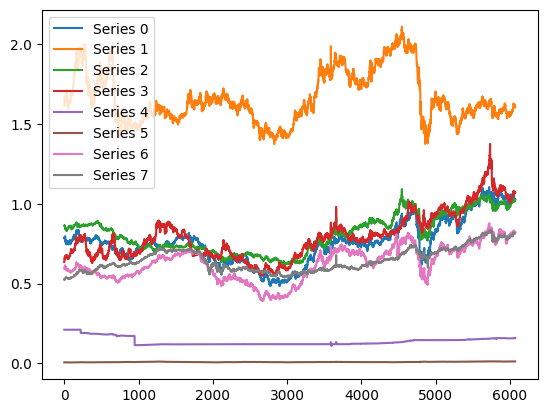

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.repository import get_dataset

dataset = get_dataset('exchange_rate')

# Plot multiple time series
for i, entry in enumerate(dataset.train):
    target = entry['target']
    feat_static_cat = entry['feat_static_cat']
    print(f'Series {i} - Static Categorical Feature: {feat_static_cat}')
    plt.plot(np.arange(target.shape[0]), target, label=f'Series {i}')
    if i == 24:  # Plot 8 time series for demonstration
        break

plt.legend()
plt.show()


In [5]:
train_grouper = MultivariateGrouper(max_target_dim=data_dim)
test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)),
                                   max_target_dim=data_dim)


ds_train = train_grouper(dataset.train)

/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:114: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  timestamp + len(data[FieldName.TARGET]) - 1,
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:243: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index=pd.period_range(
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:243: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index=pd.period_range(
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:188: FutureWarning: Period with BDay freq is deprecated a

In [18]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import InstanceSplitter, InstanceSampler, ExpectedNumInstanceSampler
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.loader import as_stacked_batches
from gluonts.torch.batchify import batchify

# Define the transformation
prediction_length = 30
context_length = 60
freq = dataset.metadata.freq

# Use InstanceSampler instead of InstanceSplitter.Sampler
sampler = InstanceSampler(
    past_length=prediction_length * 2,
    future_length=prediction_length
)

splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    # time_series_fields=[
    #     FieldName.FEAT_AGE,
    #     FieldName.FEAT_DYNAMIC_REAL,
    #     FieldName.OBSERVED_VALUES,
    # ],
)
# print(next(iter(dataset.train)))
transformed_ds = splitter(iter(dataset.train),is_train=True)
entry = next(iter(transformed_ds))
past = entry['past_target']
future = entry['future_target']
# print(past.shape)
# print(future.shape)
# plt.plot(np.arange(past.shape[0]),past)
# plt.plot(np.arange(past.shape[0], past.shape[0]+future.shape[0]),future)
# plt.show()
# Create the DataLoader
train_dataloader = TrainDataLoader(
    dataset=ds_train,
    transform=splitter,
    batch_size=32,
    num_batches_per_epoch=50,
    stack_fn=batchify
)
print('helllo')
print(type(train_dataloader))

helllo
<class 'gluonts.itertools.IterableSlice'>


/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/transform/split.py:150: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  entry[self.start_field] + idx + self.lead_time


In [22]:
i = 0
for batch in train_dataloader:
    print(i)
    print(batch.keys())
    print(batch['past_target'].shape)
    print(batch['future_target'].shape)
    if i == 0:
        break
    i+=1
    
    

0
dict_keys(['start', 'feat_static_cat', 'past_target', 'future_target', 'past_is_pad', 'forecast_start'])
torch.Size([32, 60, 8])
torch.Size([32, 30, 8])


/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/transform/split.py:150: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  entry[self.start_field] + idx + self.lead_time


In [21]:
def get_transformed_dataset(name, batch_size, num_batches_per_epoch):
    dataset = get_dataset(name)
    data_dim = dataset.metadata.feat_static_cat[0].cardinality


    train_grouper = MultivariateGrouper(max_target_dim=data_dim)
    test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)),
                                   max_target_dim=data_dim)


    train_ds = train_grouper(dataset.train)
    test_ds = test_grouper(dataset.test)

    # Define the transformation
    prediction_length = 30
    context_length = 60


    splitter = InstanceSplitter(
        target_field=FieldName.TARGET,
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=ExpectedNumInstanceSampler(
            num_instances=1,
            min_future=prediction_length,
        ),
        past_length=context_length,
        future_length=prediction_length
    )


    # Create the DataLoader
    train_dataloader = TrainDataLoader(
        dataset=train_ds,
        transform=splitter,
        batch_size=batch_size,
        num_batches_per_epoch=num_batches_per_epoch,
        stack_fn=batchify
    )
    test_dataloader = TrainDataLoader(
        dataset=test_ds,
        transform=splitter,
        batch_size=batch_size,
        num_batches_per_epoch=num_batches_per_epoch,
        stack_fn=batchify
    )
    return train_dataloader, test_dataloader

train_ds, test_ds = get_transformed_dataset('exchange_rate',32,50)

/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:114: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  timestamp + len(data[FieldName.TARGET]) - 1,
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:243: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index=pd.period_range(
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:243: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index=pd.period_range(
/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/gluonts/dataset/multivariate_grouper.py:188: FutureWarning: Period with BDay freq is deprecated a